In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import copy
from math import inf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
!pip3 install lightgbm
import lightgbm as lgb

# reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


# Load Preprocessed Data

In [3]:
POSSIBLE_DIRS = [
    "from_kaggle/cleaned_data",
    "/kaggle/working",
    "/kaggle/input",
]

def find_clean_paths():
    for d in POSSIBLE_DIRS:
        train_candidate = os.path.join(d, "train_clean_v2.csv")
        test_candidate = os.path.join(d, "test_clean_v2.csv")
        if os.path.exists(train_candidate) and os.path.exists(test_candidate):
            return train_candidate, test_candidate
    raise FileNotFoundError("Could not find train_clean.csv and test_clean.csv in known locations.")

train_clean_path, test_clean_path = find_clean_paths()
print("Train clean path:", train_clean_path)
print("Test clean  path:", test_clean_path)

train_df = pd.read_csv(train_clean_path)
test_df = pd.read_csv(test_clean_path)

print("Train_clean shape:", train_df.shape)
print("Test_clean shape :", test_df.shape)
train_df.head()


Train clean path: from_kaggle/cleaned_data/train_clean_v2.csv
Test clean  path: from_kaggle/cleaned_data/test_clean_v2.csv
Train_clean shape: (8693, 50072)
Test_clean shape : (4277, 50071)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerNumber,CabinNum,TotalSpend,...,deck_side_D_S,deck_side_E_P,deck_side_E_S,deck_side_F_P,deck_side_F_S,deck_side_G_P,deck_side_G_S,deck_side_T_P,deck_side_T_S,deck_side_UNK_UNK
0,0.720932,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0.0,-0.490655,-1.181321,-0.510541,...,0,0,0,0,0,0,0,0,0,0
1,-0.332557,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,1.0,-0.490655,-1.181321,-0.248363,...,0,0,0,0,1,0,0,0,0,0
2,2.055350,-0.273285,1.998823,-0.292365,5.732776,-0.215170,0.0,-0.490655,-1.181321,3.188082,...,0,0,0,0,0,0,0,0,0,0
3,0.299536,-0.340290,0.536429,0.342766,2.706059,-0.091947,0.0,0.468615,-1.181321,1.333249,...,0,0,0,0,0,0,0,0,0,0
4,-0.894417,0.131863,-0.237179,-0.033861,0.235342,-0.255389,1.0,-0.490655,-1.179351,-0.121906,...,0,0,0,0,1,0,0,0,0,0


# Prepare Features and Target

In [4]:
target_col = "Transported"

if train_df[target_col].dtype == bool:
    train_df[target_col] = train_df[target_col].astype(int)
elif train_df[target_col].dtype == object:
    mapping = {"True": 1, "False": 0, "true": 1, "false": 0}
    train_df[target_col] = train_df[target_col].map(mapping).astype(int)
else:
    train_df[target_col] = train_df[target_col].astype(int)

feature_cols = [c for c in train_df.columns if c != target_col]
print("Number of features:", len(feature_cols))

X = train_df[feature_cols].values
y = train_df[target_col].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape


Number of features: 50071


((6954, 50071), (1739, 50071))

# Helper Functions

In [5]:
def plot_confusion_matrix(cm, class_names=("Not Transported", "Transported"), title="Confusion Matrix"):
    plt.figure(figsize=(4, 4))
    im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


# Single Train/Validation LightGBM Model

In [15]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# params = {
#     "objective": "binary",
#     "metric": "binary_logloss",
#     "learning_rate": 0.05,
#     "num_leaves": 31,
#     "feature_fraction": 0.8,
#     "bagging_fraction": 0.8,
#     "bagging_freq": 1,
#     "min_data_in_leaf": 20,
#     "verbosity": -1,
#     "seed": 42,
# }
# params = {
#     "objective": "binary",
#     "metric": "binary_logloss",
#     "learning_rate": 0.03,
#     "num_leaves": 48,
#     "max_depth": -1, 
#     "min_data_in_leaf": 25,
#     "lambda_l1": 1.0,
#     "lambda_l2": 2.0,
#     "feature_fraction": 0.75,
#     "bagging_fraction": 0.7,
#     "bagging_freq": 1,
#     "min_gain_to_split": 0.01,
#     "verbosity": -1,
#     "seed": 42,
# }
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.02,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 20,
    "verbosity": -1,
    "seed": 42,
}

evals_result = {}

callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=50),
    lgb.record_evaluation(evals_result),
]

best_model = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    valid_names=["train", "valid"],
    callbacks=callbacks,
)

print("Best iteration:", best_model.best_iteration)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.459915	valid's binary_logloss: 0.470321
[100]	train's binary_logloss: 0.388436	valid's binary_logloss: 0.410431
[150]	train's binary_logloss: 0.352424	valid's binary_logloss: 0.385417
[200]	train's binary_logloss: 0.328031	valid's binary_logloss: 0.373532
[250]	train's binary_logloss: 0.308975	valid's binary_logloss: 0.367574
[300]	train's binary_logloss: 0.292371	valid's binary_logloss: 0.36415
[350]	train's binary_logloss: 0.278088	valid's binary_logloss: 0.363474
[400]	train's binary_logloss: 0.264829	valid's binary_logloss: 0.361572
[450]	train's binary_logloss: 0.252836	valid's binary_logloss: 0.361009
[500]	train's binary_logloss: 0.241419	valid's binary_logloss: 0.360289
[550]	train's binary_logloss: 0.231054	valid's binary_logloss: 0.360855
Early stopping, best iteration is:
[472]	train's binary_logloss: 0.247458	valid's binary_logloss: 0.360271
Best iteration: 472


In [7]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

base_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "bagging_freq": 1,
    "verbosity": -1,
    "seed": 42,
}

search_space = {
    "learning_rate": [0.01, 0.02, 0.03],
    "num_leaves": [16, 31, 48],
    "min_data_in_leaf": [15, 20, 30],
    "feature_fraction": [0.7, 0.8, 0.9],
    "bagging_fraction": [0.7, 0.8, 0.9],
    "lambda_l2": [0.0, 1.0, 5.0],
}

# helpers for looping
keys = list(search_space.keys())
value_lists = [search_space[k] for k in keys]

best_model = None
best_params = None
best_score = inf  # lower binary_logloss is better

trial = 0

for values in itertools.product(*value_lists):
    trial += 1
    params = copy.deepcopy(base_params)
    for k, v in zip(keys, values):
        params[k] = v

    print(f"\ntrial {trial} params:", params)

    temp_evals_result = {}
    callbacks = [
        lgb.early_stopping(stopping_rounds=100),
        lgb.record_evaluation(temp_evals_result),
    ]

    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[train_data, val_data],
        valid_names=["train", "valid"],
        callbacks=callbacks,
    )

    # get best validation binary_logloss
    # model.best_score is a dict like {"train": {...}, "valid": {"binary_logloss": value}}
    val_logloss = model.best_score["valid"]["binary_logloss"]
    print("  best iter:", model.best_iteration, "valid logloss:", val_logloss)

    if val_logloss < best_score:
        eval_result = temp_evals_result
        best_score = val_logloss
        best_model = model
        best_params = params
        print("  new best score, updating best_model and best_params")

print("\nfinished search")
print("best validation logloss:", best_score)
print("best params:", best_params)
print("best iteration:", best_model.best_iteration)



trial 1 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1303]	train's binary_logloss: 0.284236	valid's binary_logloss: 0.363768
  best iter: 1303 valid logloss: 0.36376768034476803
  new best score, updating best_model and best_params

trial 2 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1785]	train's binary_logloss: 0.265548	valid's binary_logloss: 0.362124
  best iter: 1785 valid logloss: 0.36212382861415027


Early stopping, best iteration is:
[1553]	train's binary_logloss: 0.295328	valid's binary_logloss: 0.363115
  best iter: 1553 valid logloss: 0.36311472215069307

trial 19 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1412]	train's binary_logloss: 0.273074	valid's binary_logloss: 0.362809
  best iter: 1412 valid logloss: 0.36280914702414613

trial 20 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1299]	train's bi

Did not meet early stopping. Best iteration is:
[1906]	train's binary_logloss: 0.281617	valid's binary_logloss: 0.362425
  best iter: 1906 valid logloss: 0.3624249735098773

trial 37 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1306]	train's binary_logloss: 0.284414	valid's binary_logloss: 0.362386
  best iter: 1306 valid logloss: 0.3623863845321414

trial 38 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1309]

Early stopping, best iteration is:
[1580]	train's binary_logloss: 0.2932	valid's binary_logloss: 0.363555
  best iter: 1580 valid logloss: 0.36355476741147064

trial 55 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1459]	train's binary_logloss: 0.280467	valid's binary_logloss: 0.362933
  best iter: 1459 valid logloss: 0.3629332876053009

trial 56 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1624]	train's binar

Early stopping, best iteration is:
[1483]	train's binary_logloss: 0.299187	valid's binary_logloss: 0.363672
  best iter: 1483 valid logloss: 0.36367185985799416

trial 73 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1299]	train's binary_logloss: 0.286711	valid's binary_logloss: 0.363757
  best iter: 1299 valid logloss: 0.3637573700809022

trial 74 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1299]	train's bin

Early stopping, best iteration is:
[1156]	train's binary_logloss: 0.263052	valid's binary_logloss: 0.363284
  best iter: 1156 valid logloss: 0.36328381275076266

trial 91 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	train's binary_logloss: 0.262153	valid's binary_logloss: 0.362515
  best iter: 805 valid logloss: 0.36251533143370623

trial 92 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1110]	train's bina

Early stopping, best iteration is:
[995]	train's binary_logloss: 0.273527	valid's binary_logloss: 0.363374
  best iter: 995 valid logloss: 0.3633737572062547

trial 109 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1049]	train's binary_logloss: 0.238745	valid's binary_logloss: 0.361982
  best iter: 1049 valid logloss: 0.3619823365873761

trial 110 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[849]	train's binar

Early stopping, best iteration is:
[1078]	train's binary_logloss: 0.267464	valid's binary_logloss: 0.361621
  best iter: 1078 valid logloss: 0.3616214940343204

trial 127 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1053]	train's binary_logloss: 0.234665	valid's binary_logloss: 0.361411
  best iter: 1053 valid logloss: 0.3614109735617179

trial 128 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1020]	train's bi

Early stopping, best iteration is:
[968]	train's binary_logloss: 0.279227	valid's binary_logloss: 0.363339
  best iter: 968 valid logloss: 0.363339253904958

trial 145 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1029]	train's binary_logloss: 0.244151	valid's binary_logloss: 0.362091
  best iter: 1029 valid logloss: 0.3620906891179218

trial 146 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1125]	train's binar

Early stopping, best iteration is:
[1080]	train's binary_logloss: 0.267077	valid's binary_logloss: 0.363012
  best iter: 1080 valid logloss: 0.36301208046731387

trial 163 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[746]	train's binary_logloss: 0.225526	valid's binary_logloss: 0.362648
  best iter: 746 valid logloss: 0.3626484286532347

trial 164 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[691]	train's bina

Early stopping, best iteration is:
[964]	train's binary_logloss: 0.236593	valid's binary_logloss: 0.363622
  best iter: 964 valid logloss: 0.3636219590787042

trial 181 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[688]	train's binary_logloss: 0.230419	valid's binary_logloss: 0.364409
  best iter: 688 valid logloss: 0.3644088135628639

trial 182 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[753]	train's binary_

Early stopping, best iteration is:
[846]	train's binary_logloss: 0.252195	valid's binary_logloss: 0.363476
  best iter: 846 valid logloss: 0.3634758338571555

trial 199 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[633]	train's binary_logloss: 0.245989	valid's binary_logloss: 0.362968
  best iter: 633 valid logloss: 0.3629678689353764

trial 200 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[763]	train's binary_

Early stopping, best iteration is:
[844]	train's binary_logloss: 0.248825	valid's binary_logloss: 0.363035
  best iter: 844 valid logloss: 0.36303459793138726

trial 217 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[746]	train's binary_logloss: 0.2366	valid's binary_logloss: 0.363344
  best iter: 746 valid logloss: 0.36334421718339704

trial 218 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[806]	train's binary_

Early stopping, best iteration is:
[960]	train's binary_logloss: 0.239207	valid's binary_logloss: 0.362372
  best iter: 960 valid logloss: 0.36237242622688165

trial 235 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[669]	train's binary_logloss: 0.244837	valid's binary_logloss: 0.362372
  best iter: 669 valid logloss: 0.3623724767846757

trial 236 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[814]	train's binary

Early stopping, best iteration is:
[850]	train's binary_logloss: 0.28949	valid's binary_logloss: 0.361562
  best iter: 850 valid logloss: 0.36156242156907387

trial 253 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[685]	train's binary_logloss: 0.278282	valid's binary_logloss: 0.364891
  best iter: 685 valid logloss: 0.3648911305060048

trial 254 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[827]	train's binary_

Early stopping, best iteration is:
[827]	train's binary_logloss: 0.28999	valid's binary_logloss: 0.363495
  best iter: 827 valid logloss: 0.36349456405501285

trial 271 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 16, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[670]	train's binary_logloss: 0.284588	valid's binary_logloss: 0.361631
  best iter: 670 valid logloss: 0.36163086937100153

trial 272 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 16, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[614]	train's binary

Early stopping, best iteration is:
[955]	train's binary_logloss: 0.279723	valid's binary_logloss: 0.362969
  best iter: 955 valid logloss: 0.3629694976071531

trial 289 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 16, 'min_data_in_leaf': 20, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[746]	train's binary_logloss: 0.271043	valid's binary_logloss: 0.36326
  best iter: 746 valid logloss: 0.36325955163701384

trial 290 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 16, 'min_data_in_leaf': 20, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[820]	train's binary_

Early stopping, best iteration is:
[824]	train's binary_logloss: 0.292593	valid's binary_logloss: 0.363446
  best iter: 824 valid logloss: 0.3634464364522053

trial 307 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[746]	train's binary_logloss: 0.276716	valid's binary_logloss: 0.363928
  best iter: 746 valid logloss: 0.3639277368371231

trial 308 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[752]	train's binary_

Early stopping, best iteration is:
[803]	train's binary_logloss: 0.292729	valid's binary_logloss: 0.362648
  best iter: 803 valid logloss: 0.3626483664886781

trial 325 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[455]	train's binary_logloss: 0.251409	valid's binary_logloss: 0.361114
  best iter: 455 valid logloss: 0.3611138635602209

trial 326 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[486]	train's binary_

Early stopping, best iteration is:
[573]	train's binary_logloss: 0.26124	valid's binary_logloss: 0.362165
  best iter: 573 valid logloss: 0.36216454224595795

trial 343 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[393]	train's binary_logloss: 0.263408	valid's binary_logloss: 0.362521
  best iter: 393 valid logloss: 0.36252060115636137

trial 344 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	train's binary

Early stopping, best iteration is:
[570]	train's binary_logloss: 0.263539	valid's binary_logloss: 0.361691
  best iter: 570 valid logloss: 0.36169083133108

trial 361 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	train's binary_logloss: 0.246358	valid's binary_logloss: 0.361178
  best iter: 483 valid logloss: 0.361178107287893

trial 362 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[471]	train's binary_log

Early stopping, best iteration is:
[680]	train's binary_logloss: 0.24369	valid's binary_logloss: 0.360816
  best iter: 680 valid logloss: 0.36081584205862244

trial 379 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	train's binary_logloss: 0.240597	valid's binary_logloss: 0.361849
  best iter: 543 valid logloss: 0.36184928077409584

trial 380 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[507]	train's binary

Early stopping, best iteration is:
[438]	train's binary_logloss: 0.286112	valid's binary_logloss: 0.363097
  best iter: 438 valid logloss: 0.36309694551015975

trial 397 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[486]	train's binary_logloss: 0.248474	valid's binary_logloss: 0.362443
  best iter: 486 valid logloss: 0.36244254760755745

trial 398 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	train's binar

Early stopping, best iteration is:
[438]	train's binary_logloss: 0.248757	valid's binary_logloss: 0.364851
  best iter: 438 valid logloss: 0.36485083223785836

trial 415 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[314]	train's binary_logloss: 0.24463	valid's binary_logloss: 0.364608
  best iter: 314 valid logloss: 0.3646081389741182

trial 416 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	train's binary_

Early stopping, best iteration is:
[423]	train's binary_logloss: 0.248133	valid's binary_logloss: 0.362677
  best iter: 423 valid logloss: 0.3626767113724821

trial 433 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 48, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	train's binary_logloss: 0.235858	valid's binary_logloss: 0.362951
  best iter: 355 valid logloss: 0.36295074105948294

trial 434 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 48, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	train's binary

Early stopping, best iteration is:
[437]	train's binary_logloss: 0.247092	valid's binary_logloss: 0.362141
  best iter: 437 valid logloss: 0.36214148172110266

trial 451 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 48, 'min_data_in_leaf': 20, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	train's binary_logloss: 0.24183	valid's binary_logloss: 0.359003
  best iter: 324 valid logloss: 0.3590026654659892
  new best score, updating best_model and best_params

trial 452 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 48, 'min_data_in_leaf': 20, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Ea

Early stopping, best iteration is:
[500]	train's binary_logloss: 0.237741	valid's binary_logloss: 0.363569
  best iter: 500 valid logloss: 0.3635688971910896

trial 469 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	train's binary_logloss: 0.247755	valid's binary_logloss: 0.363285
  best iter: 332 valid logloss: 0.3632850720382897

trial 470 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.02, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[392]	train's binary_

Early stopping, best iteration is:
[420]	train's binary_logloss: 0.251006	valid's binary_logloss: 0.363695
  best iter: 420 valid logloss: 0.36369512944592874

trial 487 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	train's binary_logloss: 0.2574	valid's binary_logloss: 0.36428
  best iter: 577 valid logloss: 0.3642797354091058

trial 488 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[563]	train's binary_lo

Early stopping, best iteration is:
[568]	train's binary_logloss: 0.287872	valid's binary_logloss: 0.363614
  best iter: 568 valid logloss: 0.3636142423878197

trial 505 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[613]	train's binary_logloss: 0.248339	valid's binary_logloss: 0.363602
  best iter: 613 valid logloss: 0.3636021443514578

trial 506 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[626]	train's binary_

Early stopping, best iteration is:
[565]	train's binary_logloss: 0.289497	valid's binary_logloss: 0.362868
  best iter: 565 valid logloss: 0.3628681569366737

trial 523 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[482]	train's binary_logloss: 0.27561	valid's binary_logloss: 0.364326
  best iter: 482 valid logloss: 0.3643258972530644

trial 524 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[484]	train's binary_l

Early stopping, best iteration is:
[565]	train's binary_logloss: 0.28729	valid's binary_logloss: 0.361453
  best iter: 565 valid logloss: 0.3614529674875784

trial 541 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	train's binary_logloss: 0.296898	valid's binary_logloss: 0.365545
  best iter: 404 valid logloss: 0.36554478839989235

trial 542 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	train's binary_

Early stopping, best iteration is:
[483]	train's binary_logloss: 0.300343	valid's binary_logloss: 0.363348
  best iter: 483 valid logloss: 0.36334843713252557

trial 559 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	train's binary_logloss: 0.294485	valid's binary_logloss: 0.363564
  best iter: 405 valid logloss: 0.3635640151170853

trial 560 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 16, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	train's binary

Early stopping, best iteration is:
[432]	train's binary_logloss: 0.252152	valid's binary_logloss: 0.362702
  best iter: 432 valid logloss: 0.36270214346630153

trial 577 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	train's binary_logloss: 0.246843	valid's binary_logloss: 0.364459
  best iter: 315 valid logloss: 0.36445860915392503

trial 578 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[328]	train's binar

Early stopping, best iteration is:
[420]	train's binary_logloss: 0.251101	valid's binary_logloss: 0.361707
  best iter: 420 valid logloss: 0.36170656926705996

trial 595 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	train's binary_logloss: 0.257167	valid's binary_logloss: 0.360317
  best iter: 299 valid logloss: 0.3603174349395681

trial 596 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	train's binary

Early stopping, best iteration is:
[399]	train's binary_logloss: 0.258418	valid's binary_logloss: 0.362202
  best iter: 399 valid logloss: 0.36220166118332175

trial 613 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	train's binary_logloss: 0.239103	valid's binary_logloss: 0.362587
  best iter: 342 valid logloss: 0.3625868735137959

trial 614 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 31, 'min_data_in_leaf': 20, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[323]	train's binary

Early stopping, best iteration is:
[423]	train's binary_logloss: 0.255274	valid's binary_logloss: 0.364781
  best iter: 423 valid logloss: 0.3647812333361407

trial 631 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	train's binary_logloss: 0.233877	valid's binary_logloss: 0.364442
  best iter: 383 valid logloss: 0.36444242494858725

trial 632 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	train's binary

Early stopping, best iteration is:
[421]	train's binary_logloss: 0.251536	valid's binary_logloss: 0.362113
  best iter: 421 valid logloss: 0.3621125549123022

trial 649 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	train's binary_logloss: 0.239329	valid's binary_logloss: 0.364114
  best iter: 221 valid logloss: 0.36411434753002947

trial 650 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	train's binary

Early stopping, best iteration is:
[302]	train's binary_logloss: 0.243364	valid's binary_logloss: 0.362989
  best iter: 302 valid logloss: 0.3629889606829997

trial 667 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	train's binary_logloss: 0.220259	valid's binary_logloss: 0.363628
  best iter: 251 valid logloss: 0.36362838912594936

trial 668 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	train's binary

Early stopping, best iteration is:
[309]	train's binary_logloss: 0.244217	valid's binary_logloss: 0.361389
  best iter: 309 valid logloss: 0.3613892092272957

trial 685 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	train's binary_logloss: 0.25696	valid's binary_logloss: 0.365333
  best iter: 193 valid logloss: 0.3653332119850099

trial 686 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	train's binary_l

Early stopping, best iteration is:
[282]	train's binary_logloss: 0.248682	valid's binary_logloss: 0.365023
  best iter: 282 valid logloss: 0.36502283466861585

trial 703 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[269]	train's binary_logloss: 0.228238	valid's binary_logloss: 0.367153
  best iter: 269 valid logloss: 0.36715315994803793

trial 704 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	train's binar

Early stopping, best iteration is:
[378]	train's binary_logloss: 0.222076	valid's binary_logloss: 0.365027
  best iter: 378 valid logloss: 0.36502740312557

trial 721 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 0.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	train's binary_logloss: 0.257564	valid's binary_logloss: 0.362255
  best iter: 200 valid logloss: 0.36225497656664735

trial 722 params: {'objective': 'binary', 'metric': 'binary_logloss', 'bagging_freq': 1, 'verbosity': -1, 'seed': 42, 'learning_rate': 0.03, 'num_leaves': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'lambda_l2': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	train's binary_l

## Training Curves

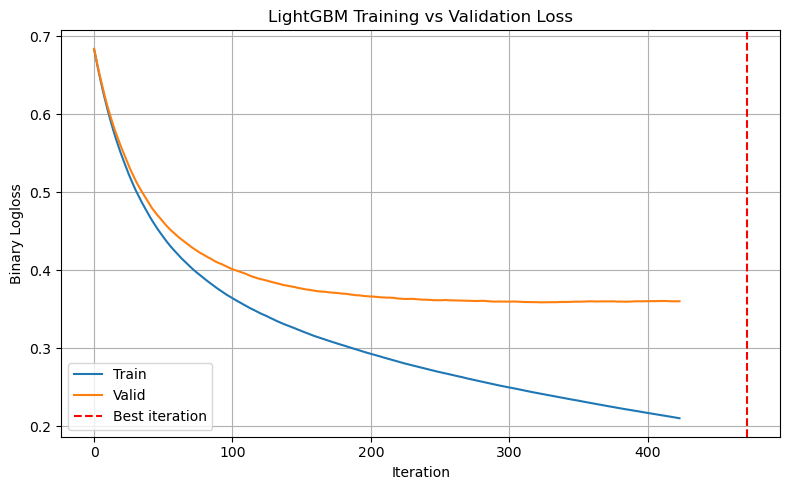

In [16]:
train_loss = eval_result["train"]["binary_logloss"]
val_loss = eval_result["valid"]["binary_logloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Valid")
plt.axvline(best_model.best_iteration, color="red", linestyle="--", label="Best iteration")
plt.xlabel("Iteration")
plt.ylabel("Binary Logloss")
plt.title("LightGBM Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


## Evaluation on Validation Set

best threshold: 0.42000000000000004
Confusion matrix:
 [[667 196]
 [113 763]]

Classification report:
               precision    recall  f1-score   support

           0     0.8551    0.7729    0.8119       863
           1     0.7956    0.8710    0.8316       876

    accuracy                         0.8223      1739
   macro avg     0.8254    0.8219    0.8218      1739
weighted avg     0.8252    0.8223    0.8218      1739



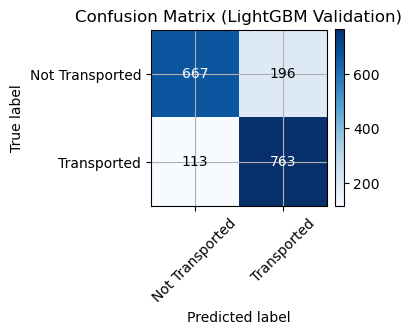

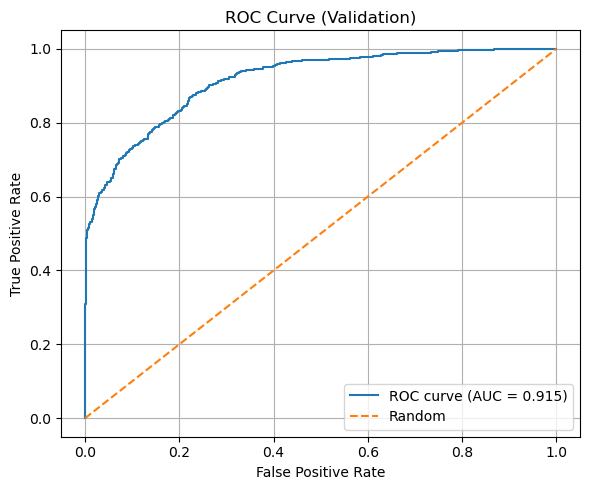

In [17]:
from sklearn.metrics import accuracy_score

# predict probabilities and labels
val_probs = best_model.predict(X_val, num_iteration=best_model.best_iteration)

# default threshold 0.5
thresholds = np.linspace(0.1, 0.9, 41)
best_acc = 0
for elem in thresholds:
    val_probs = best_model.predict(X_val, num_iteration=best_model.best_iteration)
    val_preds = (val_probs >= elem).astype(int)
    acc = accuracy_score(y_val, val_preds)
    if acc > best_acc:
        best_acc = acc
        best_threshold = elem
        
print("best threshold:", best_threshold)
val_probs = best_model.predict(X_val, num_iteration=best_model.best_iteration)
val_preds = (val_probs >= best_threshold).astype(int)

cm = confusion_matrix(y_val, val_preds)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_val, val_preds, digits=4))

plot_confusion_matrix(cm, title="Confusion Matrix (LightGBM Validation)")

fpr, tpr, _ = roc_curve(y_val, val_probs)
auc = roc_auc_score(y_val, val_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Importance

In [18]:
importances = best_model.feature_importance(importance_type="gain")
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(20)


,feature,importance
8,TotalSpend,29052.596117
7,CabinNum,10225.686287
28,cryo_zero_spend,6817.422853
13009,HomePlanet_Earth,6085.506756
10,FoodCourt_log,5696.822596
4,Spa,5485.398727
14,TotalSpend_log,5471.357903
0,Age,4900.782041
5,VRDeck,4835.441732
20,surname_avg_spend,4675.711044


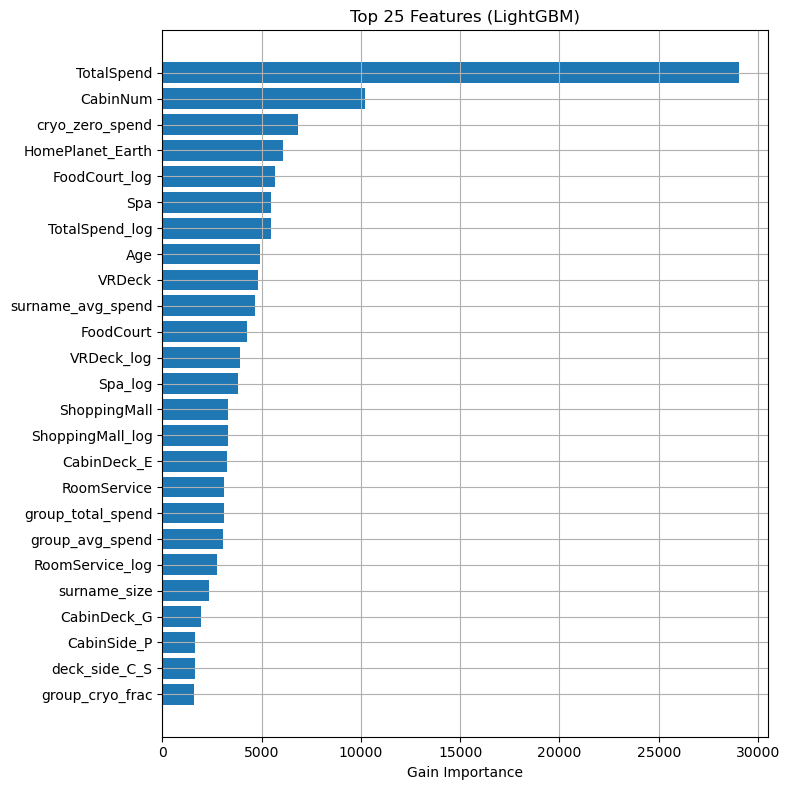

In [19]:
top_n = 25
plt.figure(figsize=(8, 8))
plt.barh(feat_imp["feature"].head(top_n)[::-1], feat_imp["importance"].head(top_n)[::-1])
plt.xlabel("Gain Importance")
plt.title(f"Top {top_n} Features (LightGBM)")
plt.tight_layout()
plt.show()


# 5-Fold Cross-Validation

In [20]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_aucs = []
fold_accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain)

    evals_result_cv = {}

    callbacks_cv = [
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=200),
        lgb.record_evaluation(evals_result_cv),
    ]

    model_cv = lgb.train(
        best_params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        callbacks=callbacks_cv,
    )

    va_probs = model_cv.predict(X_va, num_iteration=model_cv.best_iteration)
    va_preds = (va_probs >= 0.5).astype(int)

    auc = roc_auc_score(y_va, va_probs)
    acc = (va_preds == y_va).mean()
    fold_aucs.append(auc)
    fold_accs.append(acc)

    print(f"Fold {fold} AUC: {auc:.4f}, ACC: {acc:.4f}")

print("\nCV AUC mean ± std:", np.mean(fold_aucs), np.std(fold_aucs))
print("CV ACC mean ± std:", np.mean(fold_accs), np.std(fold_accs))



=== Fold 1 ===
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.290049	valid's binary_logloss: 0.375103
[400]	train's binary_logloss: 0.213425	valid's binary_logloss: 0.373352
Early stopping, best iteration is:
[316]	train's binary_logloss: 0.240293	valid's binary_logloss: 0.371336
Fold 1 AUC: 0.9097, ACC: 0.8177

=== Fold 2 ===
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.286047	valid's binary_logloss: 0.39454
[400]	train's binary_logloss: 0.209315	valid's binary_logloss: 0.392422
Early stopping, best iteration is:
[313]	train's binary_logloss: 0.238103	valid's binary_logloss: 0.391081
Fold 2 AUC: 0.8994, ACC: 0.8091

=== Fold 3 ===
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.288442	valid's binary_logloss: 0.383227
[400]	train's binary_logloss: 0.211945	valid's binary_logloss: 0.37998
Early stopping, best iteration is:
[362]	train's binary_lo

# Test Predictions and Submission File

In [14]:
import pandas as pd
import os
import numpy as np

POSSIBLE_DIRS = [
    "from_kaggle",
    "from_kaggle/cleaned_data",
    "/kaggle/working",
    "/kaggle/input",
]

final_num_boost_round = best_model.best_iteration
if final_num_boost_round is None:
    final_num_boost_round = 500 

full_train_data = lgb.Dataset(X, label=y)

model_final = lgb.train(
    best_params,
    full_train_data,
    num_boost_round=final_num_boost_round,
    valid_sets=[full_train_data],
    valid_names=["train"],
)

X_test = test_df[feature_cols].values
test_probs = model_final.predict(X_test)

test_preds = (test_probs >= best_threshold).astype(int)

POSSIBLE_DIRS = [
    "from_kaggle",
    "from_kaggle/cleaned_data",
    "/kaggle/input/spaceship-titanic",
    "/kaggle/input",
    "/mnt/data",
]

def find_original_test_path():
    for d in POSSIBLE_DIRS:
        candidate = os.path.join(d, "test.csv")
        if os.path.exists(candidate):
            return candidate
    raise FileNotFoundError("Could not find original test.csv in known locations.")

orig_test_path = find_original_test_path()
orig_test = pd.read_csv(orig_test_path)

submission = pd.DataFrame({
    "PassengerId": orig_test["PassengerId"].astype(str),
    "Transported": test_preds.astype(bool)
})

# verify column order just to be explicit
submission = submission[["PassengerId", "Transported"]]

submission_path = "lightgbm_hp_sweep.csv"
submission.to_csv(submission_path, index=False)
print("Saved submission to:", submission_path)
submission.head()


Saved submission to: lightgbm_hp_sweep.csv


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
